In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.utils import np_utils
from keras.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, normalize


Using TensorFlow backend.


In [2]:
# Model Display
from IPython.display import SVG
import pydot, pydotplus, graphviz
from keras.utils import model_to_dot

In [3]:
# Set filenames here
cf = 'data/covid_cases.csv' # Case time series
df = 'data/covid_deaths.csv' # Death time series

In [4]:
# Load and shape data
casesdf = pd.read_csv(cf).iloc[:,11:].apply(sum).values
deathdf = pd.read_csv(df).iloc[:,12:].apply(sum).values
casesdf = casesdf.reshape(len(casesdf), 1)
deathdf = deathdf.reshape(len(deathdf), 1)

In [5]:
#dataset = casesdf
dataset = deathdf

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [7]:
# Getters
def get_dataset(dataset, n_steps=1, split=0.75, shuff=False):
    #print(dataset.shape)
    X, y = [], []
    for i in range(len(dataset) - n_steps - 1):
        a = dataset[i:(i+n_steps)]
        X.append(a)
        y.append(dataset[i + n_steps][0])
    X, y = np.array(X), np.array(y)
    return train_test_split(X, y, test_size=(1-split), shuffle=shuff)

def get_model(n_steps, n_features):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, 
                     activation='relu', 
                     input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
    return model

def get_lstm(n_steps, n_features):
    model = Sequential()
    model.add(LSTM(128, input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss='mse', metrics=['mae', 'mse'])
    return model

def get_stacked_lstm(n_steps, n_features):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(128, input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss='mse', metrics=['mae', 'mse'])
    return model

def evaluate_model(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_test(y, y_hat):
    plt.plot(y, 'bo-', label='Actual')
    plt.plot(y_hat, 'ro-', label='Predicted')
    plt.show()

In [8]:
# Settings
n_steps = 5
n_features = 1
tr_split = .8

In [9]:
# Get it
X_train, X_test, Y_train, Y_test = get_dataset(dataset, n_steps, tr_split, False)
cnn = get_model(n_steps, n_features)
lstm = get_lstm(n_steps, n_features)
slstm = get_stacked_lstm(n_steps, n_features)

In [10]:
# Fit it
cnnhistory = cnn.fit(X_train, Y_train,
                       epochs=100,
                       validation_split=0.1,
                       verbose=0,
                       shuffle=False)

In [11]:
lstmhistory = lstm.fit(X_train, Y_train,
                       epochs=200,
                       validation_split=0.1,
                       verbose=0,
                       shuffle=False)

In [12]:
slstmhistory = slstm.fit(X_train, Y_train,
                        epochs=200,
                        validation_split=0.1,
                        verbose=0,
                        shuffle=False)

In [13]:
closs, cmae, cmse = cnn.evaluate(X_test, Y_test, verbose=2)
print(f'Model: CNN | Loss: {closs:.3f} | MAE: {cmae:.3f} | MSE: {cmse:.3f}')

Model: CNN | Loss: 0.007 | MAE: 0.073 | MSE: 0.007


In [14]:
lloss, lmae, lmse = lstm.evaluate(X_test, Y_test, verbose=2)
print(f'Model: LSTM | Loss: {lloss:.3f} | MAE: {lmae:.3f} | MSE: {lmse:.3f}')

Model: LSTM | Loss: 0.132 | MAE: 0.348 | MSE: 0.132


In [15]:
sloss, smae, smse = slstm.evaluate(X_test, Y_test, verbose=2)
print(f'Model: CNN | Loss: {sloss:.3f} | MAE: {smae:.3f} | MSE: {smse:.3f}')


Model: CNN | Loss: 0.085 | MAE: 0.284 | MSE: 0.085


In [16]:
ys    = scaler.inverse_transform(Y_test.reshape(len(Y_test), 1))

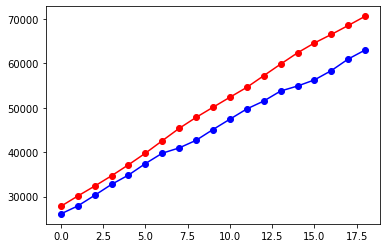

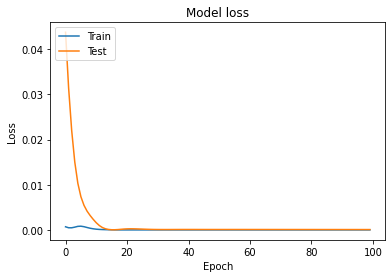

In [17]:
cpreds = scaler.inverse_transform(cnn.predict(X_test))
plot_test(ys, cpreds)
evaluate_model(cnnhistory)

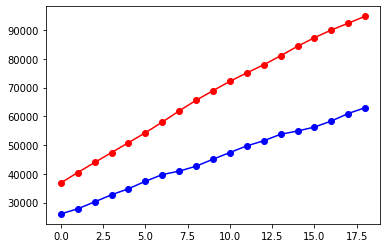

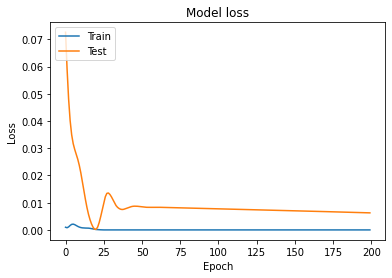

In [18]:
lpreds = scaler.inverse_transform(lstm.predict(X_test))
plot_test(ys, lpreds)
evaluate_model(lstmhistory)

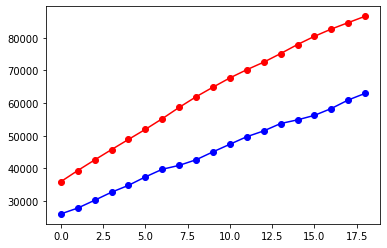

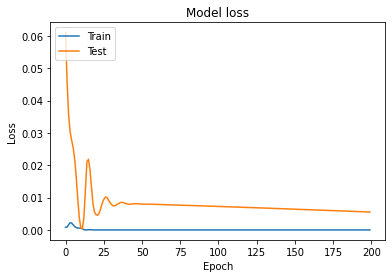

In [19]:
spreds = scaler.inverse_transform(slstm.predict(X_test))
plot_test(ys, spreds)
evaluate_model(slstmhistory)